<a href="https://colab.research.google.com/github/DDiekmann/Applied-Verification-Lab-Neural-Networks/blob/main/Tutorials/robustness_group1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applied Verification Lab: Neural Networks
Gruppe 1

summer term 2022

## Aufgabe 1
Deductive / Contraint Based Verification



In [1]:
# install z3 solver
%pip install z3-solver

Note: you may need to restart the kernel to use updated packages.


In [1]:
import time

import torch
from torch import nn
from torch.autograd import Variable

from z3 import *
import numpy as np

import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### load data

In [2]:
# https://janakiev.com/blog/pytorch-iris/
# https://en.wikipedia.org/wiki/Iris_flower_data_set

iris = load_iris()
X = iris['data']
y = iris['target']

names = iris['target_names']
feature_names = iris['feature_names']

# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
X_scaled = StandardScaler().fit_transform(X)

### plot data

In [3]:
print(feature_names)
print(names)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']


In [4]:
print(X.shape)

(150, 4)


In [5]:
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [7]:
print(X[0])
print(X_scaled[0])
print(y[0])

[5.1 3.5 1.4 0.2]
[-0.90068117  1.01900435 -1.34022653 -1.3154443 ]
0


In [8]:
def show_plots(X, y, fixed_input_y = None, epsilon = None):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
  for target, target_name in enumerate(names):
      X_plot = X[y == target]
      ax1.plot(X_plot[:, 0], X_plot[:, 1], 
              linestyle='none', 
              marker='o', 
              label=target_name)
  ax1.set_xlabel(feature_names[0])
  ax1.set_ylabel(feature_names[1])
  ax1.axis('equal')
  ax1.legend()

  for target, target_name in enumerate(names):
      X_plot = X[y == target]
      ax2.plot(X_plot[:, 2], X_plot[:, 3], 
              linestyle='none', 
              marker='o', 
              label=target_name)
  ax2.set_xlabel(feature_names[2])
  ax2.set_ylabel(feature_names[3])
  ax2.axis('equal')
  ax2.legend()

  if fixed_input_y is not None and epsilon is not None:
    circle = plt.Circle((X[0][0], X[0][1]), 0.2, color='r', fill=False)
    ax1.set_aspect("equal", adjustable="datalim")
    ax1.add_patch(circle)

    circle = plt.Circle((X[0][2], X[0][3]), 0.2, color='r', fill=False)
    ax2.set_aspect("equal", adjustable="datalim")
    ax2.add_patch(circle)

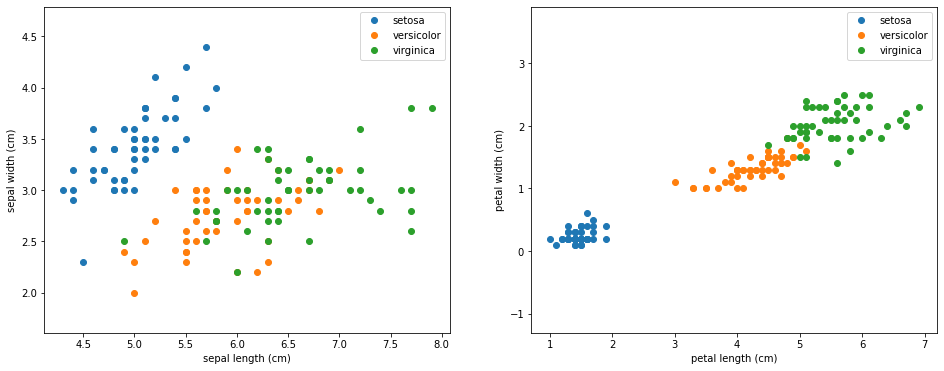

In [9]:
show_plots(X, y)

### Define a neural network

In [10]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, number_of_neurons),
            nn.ReLU(),
            nn.Linear(number_of_neurons, number_of_neurons),
            nn.ReLU(),
            nn.Linear(number_of_neurons, output_dim),
            #nn.Softmax(dim=1)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

Using cuda device


In [11]:
def train(X, y, model, loss_fn, optimizer):
    model.train()
    
    # convert numpy array to pytorch tensor
    X = Variable(torch.from_numpy(X)).float()
    y = Variable(torch.from_numpy(y)).long()
    X = X.to(device)
    y = y.to(device)

    # Compute prediction error
    pred = model(X)
    loss = loss_fn(pred, y)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss = loss.item()
    print(f"loss: {loss:>7f}")

def predict(X, model):
    model.eval()
    with torch.no_grad():
        X = Variable(torch.from_numpy(X)).float()
        X = X.to(device)
        pred = model(X)
        pred = pred.argmax(1)
        pred = pred.cpu().detach().numpy()
    return pred

def test(X, y, model, loss_fn):
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        X = Variable(torch.from_numpy(X)).float()
        y = Variable(torch.from_numpy(y)).long()
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        test_loss += loss_fn(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    correct /= X.shape[0]
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [12]:
def train_model(model):
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

  epochs = 100
  for t in range(epochs):
      print(f"Epoch {t+1}\n-------------------------------")
      train(X_train, y_train, model, loss_fn, optimizer)
      test(X_test, y_test, model, loss_fn)
  print("Done!")

### Train a neural network

In [13]:
# Split the data set into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X,  # CHANGE HERE TO SCALING IF DESIRED
    y,
    test_size=0.2, random_state=2)
print("training set", X_train.shape)
print("test set", X_test.shape)

training set (120, 4)
test set (30, 4)


In [14]:
torch.manual_seed(0)
number_of_neurons = 20

model = NeuralNetwork(X_train.shape[1], 3).to(device)
print(model)

train_model(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=4, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=3, bias=True)
  )
)
Epoch 1
-------------------------------
loss: 1.144112
Test Error: 
 Accuracy: 73.3%, Avg loss: 1.083378 

Epoch 2
-------------------------------
loss: 1.129105
Test Error: 
 Accuracy: 73.3%, Avg loss: 1.072973 

Epoch 3
-------------------------------
loss: 1.114599
Test Error: 
 Accuracy: 73.3%, Avg loss: 1.062878 

Epoch 4
-------------------------------
loss: 1.100417
Test Error: 
 Accuracy: 73.3%, Avg loss: 1.053025 

Epoch 5
-------------------------------
loss: 1.086648
Test Error: 
 Accuracy: 73.3%, Avg loss: 1.043662 

Epoch 6
-------------------------------
loss: 1.073453
Test Error: 
 Accuracy: 70.0%, Avg loss: 1.034826 

Epoch 7
-------------------------------
loss: 1.060960
Test Error: 
 Accuracy: 70.0%, Avg lo

### show neural network plots on training and test data

In [15]:
predictions = predict(X, model)

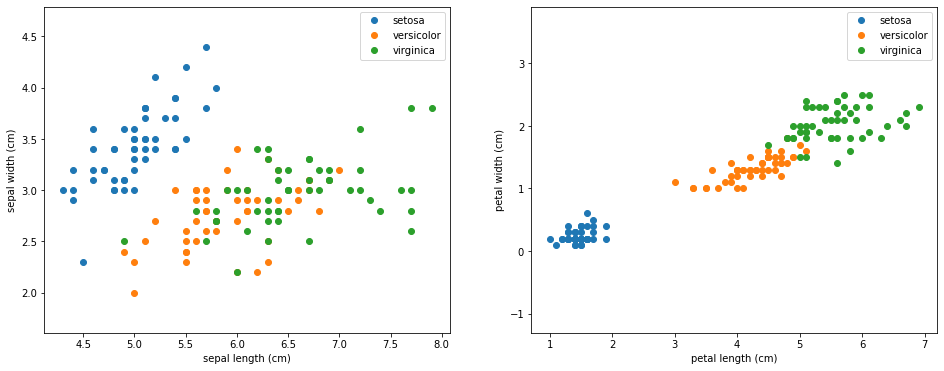

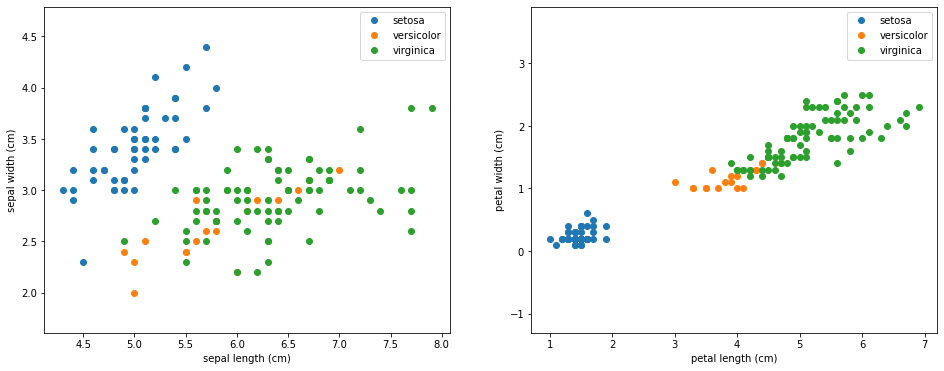

In [16]:
show_plots(X, y)
show_plots(X, predict(X, model))

# Neural Net Verfication

based on this [colab notebook](https://colab.research.google.com/github/philzook58/z3_tutorial/blob/master/Z3%20Tutorial.ipynb#scrollTo=cA_hZ2U3jO4A)

In [17]:
for name, param in model.named_parameters():
  print(name, param.cpu().detach().numpy().shape)
  #print(f"{name} : {param.cpu().detach().numpy()}")

linear_relu_stack.0.weight (20, 4)
linear_relu_stack.0.bias (20,)
linear_relu_stack.2.weight (20, 20)
linear_relu_stack.2.bias (20,)
linear_relu_stack.4.weight (3, 20)
linear_relu_stack.4.bias (3,)


In [18]:
def relu(x):
  return If(x >= 0, x, RealVal(0))

def verify(fixed_input_y, fixed_input_y_class, epsilon, model):
  # Unpack weights of the trained model
  w1, b1, w2, b2, w3, b3 = [param.cpu().detach().numpy() for param in model.parameters()]

  x0 = RealVector("x0", 4)
  x1 = RealVector("x1", number_of_neurons)
  x2 = RealVector("x2", number_of_neurons)
  output = RealVector("output", 3)

  # pre-condition
  # basically L_infinity-distance in boolean speak
  and_parts = []
  for i, x_vi in enumerate(x0):
    and_parts.append(And((x_vi - fixed_input_y[i]) <= epsilon, (fixed_input_y[i] - x_vi) <= epsilon))
  pre_cond = And(and_parts)
  #print(pre_cond)

  # assign
  and_parts = []
  for x, w, b in zip(x1, w1, b1):
    and_parts.append(x == relu(w @ x0 + b))

  for x, w, b in zip(x2, w2, b2):
    and_parts.append(x == relu(w @ x1 + b))

  for x, w, b in zip(output, w3, b3):
    and_parts.append(x == (w @ x2 + b))
  assign = And(and_parts)

  # post-condition
  # x_vo = x_v'
  and_parts = []
  for i, x_vo in enumerate(output):
    # l is the argmax of fixed_input_y
    and_parts.append(x_vo <= output[fixed_input_y_class])
  post_cond = And(and_parts)

  # verification conditions
  verification_cond = Implies(And(pre_cond, assign), post_cond)

  # prove using Z3
  prove(verification_cond)

In [25]:
def relu_vector(x):
  return np.vectorize(lambda y: If(y >= 0 , y, RealVal(0)))(x)

def net(x, w1, b1, w2, b2, w3, b3):
    x1 = w1 @ x + b1
    y1 = relu_vector(x1)
    x2 = w2 @ y1 + b2
    y2 = relu_vector(x2)
    x3 = w3 @ y2 + b3
    return x3

def verify_simple(fixed_input_y, fixed_input_y_class, epsilon, model):
  w1, b1, w2, b2, w3, b3 = [param.cpu().detach().numpy() for param in model.parameters()]

  x = RealVector("x", 4)

  # pre-condition
  # basically L_infinity-distance in boolean speak
  and_parts = []
  for i, x_vi in enumerate(x):
    and_parts.append(And((x_vi - fixed_input_y[i]) <= epsilon, (fixed_input_y[i] - x_vi) <= epsilon))
  pre_cond = And(and_parts)

  # post-condition
  # x_vo = x_v'
  output = net(x, w1, b1, w2, b2, w3, b3)
  and_parts = []
  for i, x_vo in enumerate(output):
    and_parts.append(x_vo <= output[fixed_input_y_class])
  post_cond = And(and_parts)

  verification_cond = Implies(pre_cond, post_cond)

  print("Pre condition: ")
  print(pre_cond)
  print("Post condition: ")
  print(post_cond)
  print("--------------")

  prove(verification_cond)

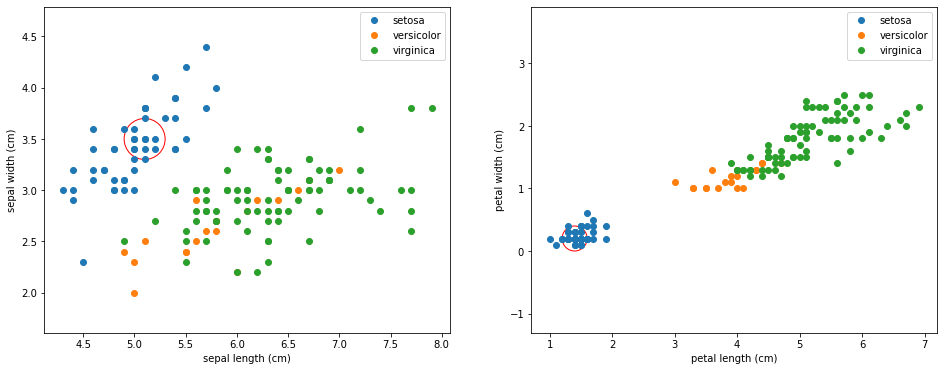

In [20]:
fixed_input_y = X[0]
fixed_input_y_class = y[0]
epsilon = 0.5

show_plots(X, predict(X, model), fixed_input_y, epsilon)

In [27]:
start_time = time.time()
verify(fixed_input_y, fixed_input_y_class, epsilon, model)
print(f"{((time.time() - start_time)/60):.2f} minutes")

proved
5.03 minutes


In [26]:
start_time = time.time()
verify_simple(fixed_input_y, fixed_input_y_class, epsilon, model)
print(f"{((time.time() - start_time)/60):.2f} minutes")

Pre condition: 
And(And(x__0 - 51/10 <= 1/2, 51/10 - x__0 <= 1/2),
    And(x__1 - 7/2 <= 1/2, 7/2 - x__1 <= 1/2),
    And(x__2 - 7/5 <= 1/2, 7/5 - x__2 <= 1/2),
    And(x__3 - 1/5 <= 1/2, 1/5 - x__3 <= 1/2))
Post condition: 
And(... +
    ... +
    ... +
    ... +
    ... +
    ... +
    ... +
    ... +
    ... +
    ... +
    ... +
    ... +
    ... +
    ... +
    ... +
    ... +
    ... +
    ... +
    ... +
    ... +
    ... <=
    ...,
    ...,
    ...)
--------------
proved
1.84 minutes
